In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import skimage

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_pictures(directory='train/'):
    with open('files_list.txt') as f:
        files_list = f.readlines()
    files_list = [(directory+i.strip()) for i in files_list]
    return files_list

In [3]:
input_shape = (128, 128, 3)
# files_list = read_pictures('preprocessed_images/')
files_list = read_pictures()

In [4]:
def preprocess_img(img):
    return skimage.transform.resize(img, input_shape)

In [5]:
def get_dataset(preprocess = True):
    X = []
    y = []
    for i in tqdm.tqdm(files_list):
        if preprocess:
            X.append(preprocess_img(plt.imread(i)))
        else:
            X.append(plt.imread(i))
            
        if 'cat' in i:
            y.append([1, 0])
        else:
            y.append([0, 1])
    return X, y

In [6]:
def save_preprocessed_images(images):
    for i, name in tqdm.tqdm(zip(images, files_list)):
        plt.imsave(f'preprocessed_images/{name.split("/")[-1]}', i)

In [7]:
X, y = get_dataset()

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [04:09<00:00, 100.27it/s]


In [ ]:
save_preprocessed_images(X)

20757it [03:34, 96.67it/s]

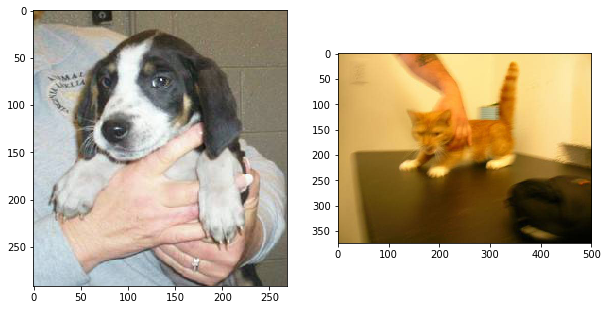

In [46]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[12502]);
plt.subplot(122)
plt.imshow(X[0])
plt.show()

In [52]:
def inference(inp):
    with tf.name_scope('classificator'):
        with tf.name_scope('convolution'):
            layer = tf.layers.conv2d(inp, 32, 6)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 16, 6)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 8, 3)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 4, 3)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 2, 3)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 1, 3)
            layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
            layer = tf.layers.conv2d(layer, 1, 3)
#         with tf.name_scope('dense'):
#             layer = tf.layers.dense(layer, 32)
#             layer = tf.layers.dense(layer, 2)
            
    return layer

In [53]:
with tf.Session() as sess:
    placeholder = tf.placeholder(tf.float32, shape=(None, 128, 128, 3))
    outputs = inference(placeholder)
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    resp = sess.run(outputs, feed_dict={placeholder: [X[0]]})

In [54]:
resp.shape

(1, 0, 2, 1)